# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [2]:
import random
import numpy as np
import utils

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate q-learning to an Atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


In [4]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing (3 pts)

Let's see what observations look like.

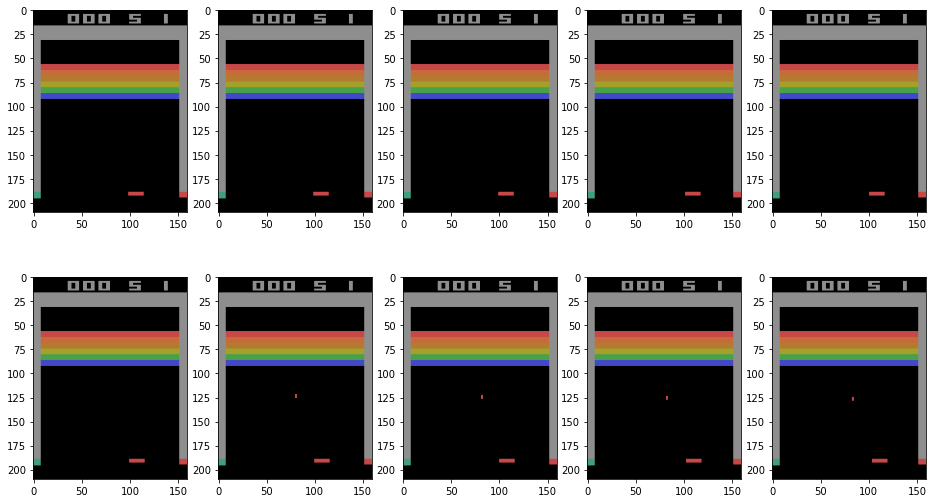

In [5]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

### Processing game image 

Raw Atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This dirty trick is not necessary but it will speed up learning.

In [6]:
from gym.core import ObservationWrapper
from gym.spaces import Box

import cv2

from sklearn.preprocessing import MinMaxScaler

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        super().__init__(env)

        self.img_size = (64, 64, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        #<YOUR CODE>
        return cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    
    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * Crop image, remove irrelevant parts.
        #  * Resize image to self.img_size. Use cv2.resize or any other library you want,
        #    e.g. PIL or Keras. Do not use skimage.transform.resize because it is roughly
        #    6x slower than cv2.resize.
        #  * Cast image to grayscale.
        #  * Convert image pixels to (0, 1) range, float32 type.

        #<YOUR CODE>
        processed_img=img[30:-15,5:-6]
        processed_img=cv2.resize(processed_img,self.img_size[:-1])
        processed_img=self._to_gray_scale(processed_img)
        processed_img=MinMaxScaler().fit_transform(processed_img)
        processed_img=processed_img.reshape(self.img_size).astype(np.float32)
        return processed_img#<YOUR CODE>

Formal tests seem fine. Here's an example of what you'll get.


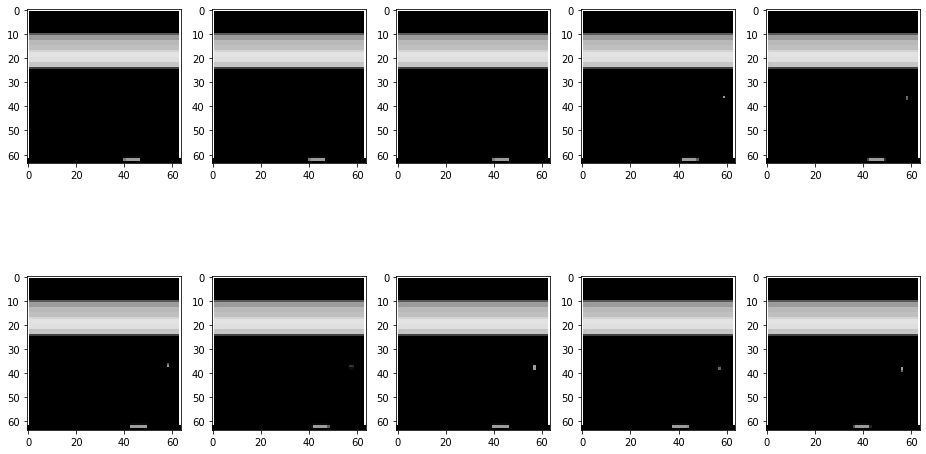

In [7]:
import gym
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()


# test observation
assert obs.ndim == 3, "observation must be [height, width, channels] even if there's just one channel"
assert obs.shape == observation_shape, (obs.shape, observation_shape)
assert obs.dtype == np.float32
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <= 1, "convert image pixels to (0,1) range"
assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

print("Formal tests seem fine. Here's an example of what you'll get.")


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[:, :, 0], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [8]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [9]:
from framebuffer import FrameBuffer


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

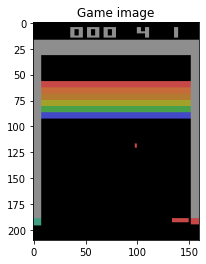

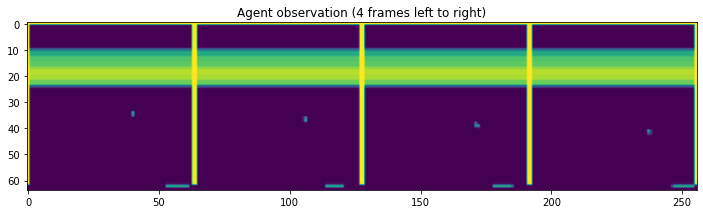

In [10]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.figure()
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[12,10])
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_shape[0], -1]))
plt.show()

## DQN as it is (4 pts)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

**Dueling network: (+2 pts)**
$$Q_{\theta}(s, a) = V_{\eta}(f_{\xi}(s)) + A_{\psi}(f_{\xi}(s), a) - \frac{\sum_{a'}A_{\psi}(f_{\xi}(s), a')}{N_{actions}},$$
where $\xi$, $\eta$, and $\psi$ are, respectively, the parameters of the
shared encoder $f_ξ$ , of the value stream $V_\eta$ , and of the advan
tage stream $A_\psi$; and $\theta = \{\xi, \eta, \psi\}$ is their concatenation.

For the architecture on the image $V$ and $A$ heads can follow the dense layer instead of $Q$. Please don't worry that the model becomes a little bigger.

In [11]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [12]:
state_shape

(64, 64, 4)

In [13]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras import models
from tensorflow import keras


class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):

            #<YOUR CODE: define your network body here. Please make sure you don't use any layers created elsewhere>
            conv2d_1=Conv2D(16,3,strides=(2,2),activation='relu',input_shape=state_shape)
            conv2d_2=Conv2D(32,3,strides=(2,2),activation='relu')
            conv2d_3=Conv2D(64,3,strides=(2,2),activation='relu')
            flatten=Flatten()
            dense=Dense(256,activation='relu')
            output=Dense(n_actions,activation='linear')
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None, ] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        #<YOUR CODE: apply your network layers here>
        qvalues = output(dense(flatten(conv2d_3(conv2d_2(conv2d_1(state_t))))))#<YOUR CODE: symbolic tensor for q-values>

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [14]:
agent = DQNAgent("dqn_agent", state_shape, n_actions, epsilon=1)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Now let's try out our agent to see if it raises any errors.

In [15]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [16]:
evaluate(env, agent, n_games=1)

1.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [17]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [18]:
from tqdm import tqdm

def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    # initial state
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    #<YOUR CODE>
    for step in tqdm(range(n_steps)):
        qvalues = agent.get_qvalues([s])
        action=agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        sum_rewards+=r
        exp_replay.add(s, action, r, next_s, done)
        s=next_s
        if done:
            env.reset()
           
    return sum_rewards, s

In [19]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

100%|██████████| 1000/1000 [00:05<00:00, 187.34it/s]


Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)



In [20]:
target_network = DQNAgent("target_network", state_shape, n_actions)

In [21]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    # tf.get_default_session().run(assigns)
    return assigns

In [22]:
# create the tf copy graph only once.
copy_step = load_weigths_into_target_network(agent, target_network)
sess.run(copy_step)
# check that it works
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)])
print("It works!")

It works!


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [23]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_shape)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_shape)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [24]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

**Double DQN (+2 pts)**

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot
Q_{target}(s',argmax_{a'}Q_\theta(s', a')) $$

In [25]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)*is_not_done#<YOUR CODE: compute q-values for NEXT states with target network>
next_state_values_target = tf.reduce_max(next_qvalues_target,axis=1)#<YOUR CODE: compute state values by taking max over next_qvalues_target for all actions>
reference_qvalues = rewards_ph+gamma*next_qvalues_target#<YOUR CODE: compute Q_reference(s,a) as per formula above>

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
sess.run(tf.global_variables_initializer())

In [27]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!"  # ignore if you're certain it's ok
print("Splendid!")

Splendid!


## Main loop (3 pts)

**If deadline is tonight and it has not converged:** It is ok. Send the notebook today and when it converges send it again.
If the code is exactly the same points will not be discounted.

It's time to put everything together and see if it learns anything.

In [28]:
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
seed = 505#<YOUR CODE: your favourite random seed>
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

sess.run(tf.global_variables_initializer())
sess.run(copy_step)

[array([[[[-3.08170170e-02, -1.57625318e-01, -1.66108966e-01,
            3.78775299e-02, -9.70212221e-02,  7.56006539e-02,
            1.07202321e-01,  7.43611455e-02, -1.99831575e-02,
            9.23036337e-02,  1.77824765e-01, -1.91342533e-02,
            5.96885532e-02,  2.62977481e-02, -1.23071328e-01,
            2.36698985e-02],
          [ 2.08452046e-02,  1.25956833e-01,  1.59576386e-01,
            8.84523988e-03,  6.53619617e-02,  1.27275407e-01,
           -1.47777379e-01, -7.54486918e-02, -3.11477929e-02,
           -8.39537010e-02,  2.59159058e-02,  3.34077030e-02,
           -1.50430784e-01, -1.72656655e-01,  8.94627571e-02,
            4.34233844e-02],
          [-1.23744503e-01, -1.66648597e-01,  2.42456794e-04,
           -9.91725996e-02, -4.86130565e-02,  1.87496245e-02,
           -9.13801789e-03,  1.28290772e-01,  1.52782410e-01,
           -1.37364671e-01, -5.96728399e-02, -8.92627314e-02,
            5.07241338e-02, -6.70021772e-03,  6.06207699e-02,
            

In [30]:
REPLAY_BUFFER_SIZE = 10**5

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
_, state = play_and_record(state, agent, env, exp_replay, n_steps=4000)


def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph: obs_batch,
        actions_ph: act_batch,
        rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch,
        is_done_ph: is_done_batch,
    }

100%|██████████| 4000/4000 [00:22<00:00, 181.02it/s]


In [31]:
timesteps_per_epoch = 10
batch_size = 64
total_steps = 3 * 10**5
decay_steps = 10**5

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 5
refresh_target_network_freq = 500
eval_freq = 500

n_lives = 5

In [32]:
mean_rw_history = []
td_loss_history = []
initial_state_v_history = []
step = 0

In [33]:
state = env.reset()

with trange(step, total_steps) as progress_bar:
    for step in progress_bar:
        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
        
        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=batch_size))
        
        if step % loss_freq == 0:
            td_loss_history.append(loss_t)
            
        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            sess.run(copy_step)

        if step % eval_freq == 0:
            # eval the agent
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.show()

  0%|          | 0/300000 [00:00<?, ?it/s]


InvalidArgumentError: Incompatible shapes: [64,4] vs. [64]
	 [[node mul_1 (defined at <ipython-input-25-479677d8e3a3>:1) ]]

Errors may have originated from an input operation.
Input Source operations connected to node mul_1:
 sub (defined at <ipython-input-23-1a14313b3289>:8)	
 model_1/dense_3/BiasAdd (defined at <ipython-input-13-8089300d1006>:32)

Original stack trace for 'mul_1':
  File "/home/ubuntu/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
    yield self.process_one()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell
    return runner(coro)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3147, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-479677d8e3a3>", line 1, in <module>
    next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)*is_not_done#<YOUR CODE: compute q-values for NEXT states with target network>
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 1180, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6490, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 15 points in the real env**. So 3 or better 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score >= 15, 'not as cool as DQN can'
print('Cool!')

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously. 
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

But hey, long training time isn't _that_ bad:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow learning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.

## Let's have a closer look at this.

If average episode score is below 200 using all 5 lives, then probably DQN has not converged fully. But anyway let's make a more complete record of an episode.

In [ ]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

### Video

In [ ]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

## Bonus I (2 pts)

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$ 
$$\hat V_{agent}(s)=\max_a \hat Q(s,a).$$ Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

In [ ]:
from utils import play_and_log_episode, img_by_obs

<YOUR CODE>

## Bonus II (1-5 pts). Get High Score!

1 point to you for each 50 points of your agent. Truncated by 5 points. Starting with 50 points, **not** 50 + threshold.

One way is to train for several days and use heavier hardware (why not actually).

Another way is to apply modifications (see **Bonus III**).

## Bonus III (2+ pts). Apply modifications to DQN.

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

Points for Bonus II and Bonus III fully stack. So if modified agent gets score 250+ you get 5 pts for Bonus II + points for modifications. If the final score is 40 then you get the points for modifications.


Some modifications:
* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (5 pts for your own implementation, 3 pts for using a ready one)
* [double q-learning](https://arxiv.org/abs/1509.06461) (2 pts)
* [dueling q-learning](https://arxiv.org/abs/1511.06581) (2 pts)
* multi-step heuristics (see [Rainbow](https://arxiv.org/abs/1710.02298)) (3 pts)
* [Noisy Nets](https://arxiv.org/abs/1706.10295) (3 pts)
* [distributional RL](https://arxiv.org/abs/1707.06887)(distributional and distributed stand for different things here) (5 pts)
* Other modifications (2+ pts depending on complexity)

## Bonus IV (4+ pts). Distributed RL.

Solve the task in a distributed way. It can strongly speed up learning. See [article](https://arxiv.org/pdf/1602.01783.pdf) or some guides.

**As usual bonus points for all the tasks fully stack.**